In [31]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/leasaab/Documents/Dev/AX3-Project/data/FemmeCardio.csv"

data = pd.read_csv(file_path)

timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data

*Visualisation du signal brut*

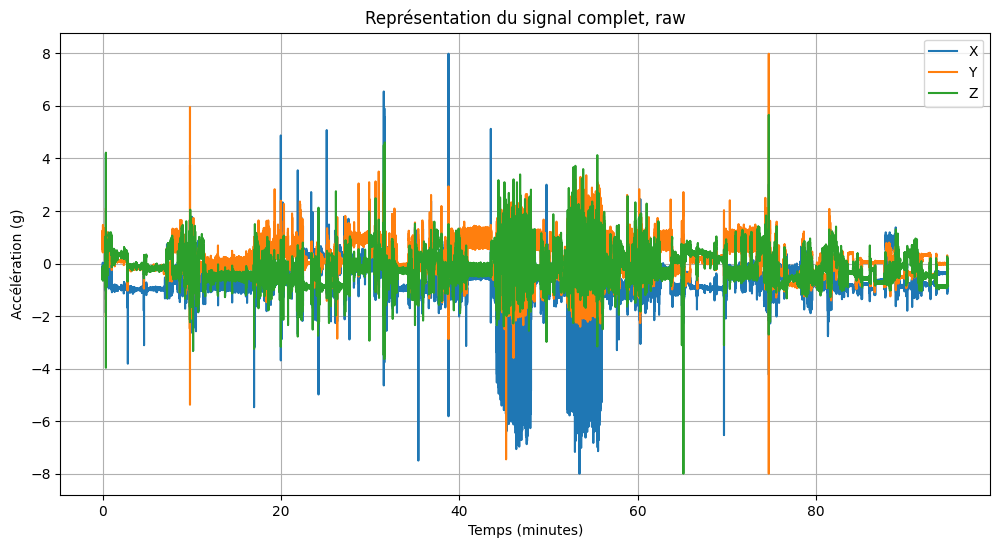

In [32]:
## Convert the timestamp column to datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column])

# Calculate the relative time in seconds
sampling_interval = (data[timestamp_column].iloc[1] - data[timestamp_column].iloc[0]).total_seconds()
data['relative_time_seconds'] = data.index * sampling_interval / 60  # Convert to minutes

# Define axis labels for clarity
axis_labels = ['X', 'Y', 'Z']

# Plot the signal for X, Y, Z axes
plt.figure(figsize=(12, 6))
for signal, axis_label in zip(signal_columns[:3], axis_labels):  # Assuming first 3 are X, Y, Z
    plt.plot(data['relative_time_seconds'], data[signal], label=axis_label)

# Add titles and labels
plt.title("Représentation du signal complet, raw")
plt.xlabel("Temps (minutes)")
plt.ylabel("Accélération (g)")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

/opt/miniconda3/envs/ax3_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


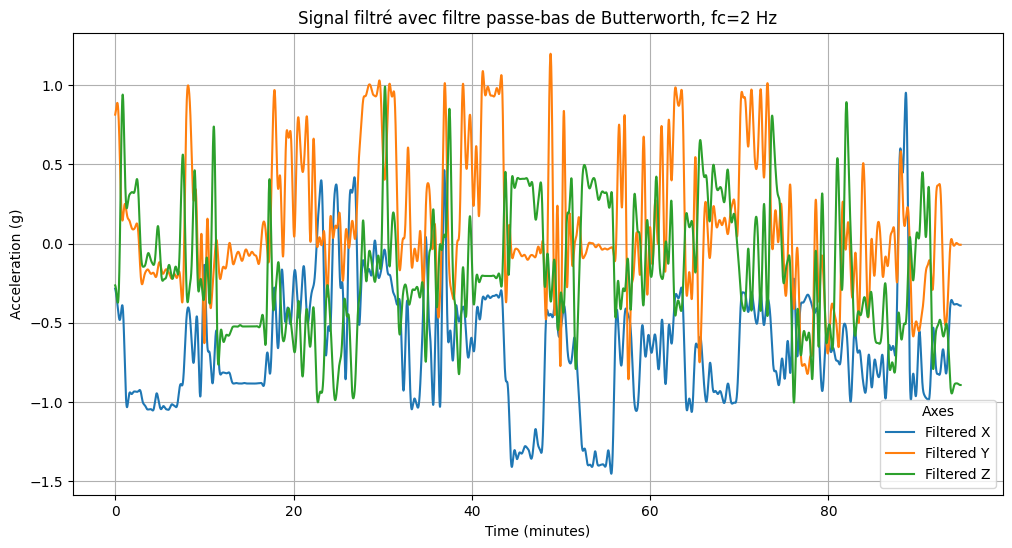

In [45]:
# Convert the timestamp column to datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column])

# Calculate the sampling interval and frequency
sampling_interval = (data[timestamp_column].iloc[1] - data[timestamp_column].iloc[0]).total_seconds()
fs = 1 / sampling_interval  # Sampling frequency in Hz

# Add relative time in minutes
data['relative_time_minutes'] = data.index * sampling_interval / 60

# Apply the low-pass filter to X, Y, Z axes
cutoff = 200  # Cutoff frequency in Hz
for signal in signal_columns[:3]:  # Assuming the first 3 columns correspond to X, Y, Z
    data[signal] = lowpass_filter(data[signal], cutoff, fs)

# Plot the low-pass filtered signals
plt.figure(figsize=(12, 6))
axis_labels = ['X', 'Y', 'Z']  # Corrected labels for X, Y, Z axes
for signal, label in zip(signal_columns[:3], axis_labels):  # Zip signal with corresponding axis labels
    plt.plot(data['relative_time_minutes'], data[signal], label=f"Filtered {label}")

# Add titles and labels to the plot
plt.title("Signal filtré avec filtre passe-bas de Butterworth, fc=2 Hz")
plt.xlabel("Time (minutes)")
plt.ylabel("Acceleration (g)")  # Assuming data is in units of gravity
plt.legend(title="Axes")
plt.grid(True)
plt.show()

In [46]:
# Assure-toi que la colonne timestamp est au format datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column])

# Calculer l'intervalle moyen entre deux échantillons
sampling_interval = (data[timestamp_column].iloc[1] - data[timestamp_column].iloc[0]).total_seconds()

# Calculer la fréquence d'échantillonnage
fs = 1 / sampling_interval
print(f"Fréquence d'échantillonnage estimée : {fs} Hz")

Fréquence d'échantillonnage estimée : 500.0 Hz


In [47]:
print(data[timestamp_column].head(2))

0   2024-10-06 15:40:04.505
1   2024-10-06 15:40:04.507
Name: 2024-10-06 15:40:04.502, dtype: datetime64[ns]


Nombre total de pics détectés : 60
Intervalle moyen entre les pics : 91.96 minutes
Cadence moyenne : 0.02 pas par minute


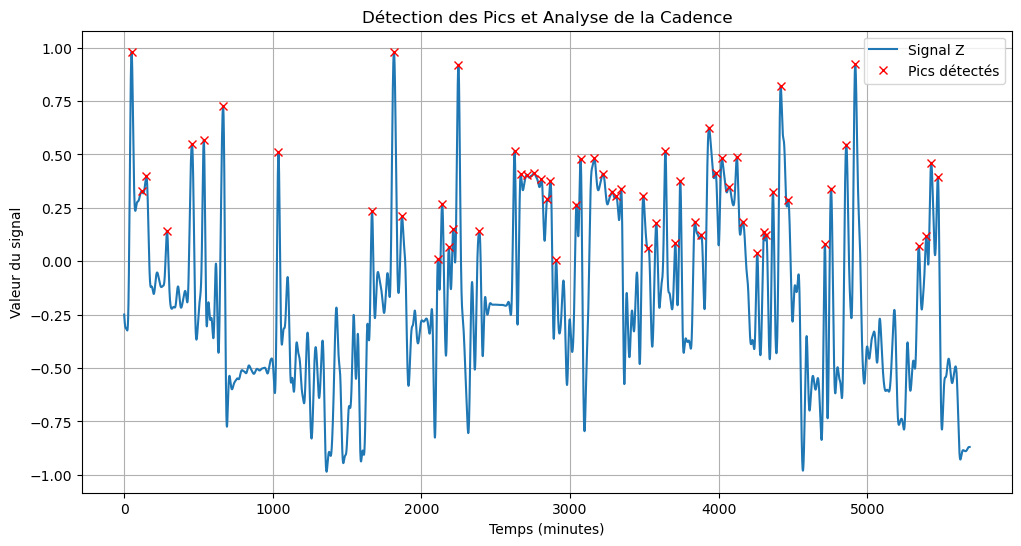

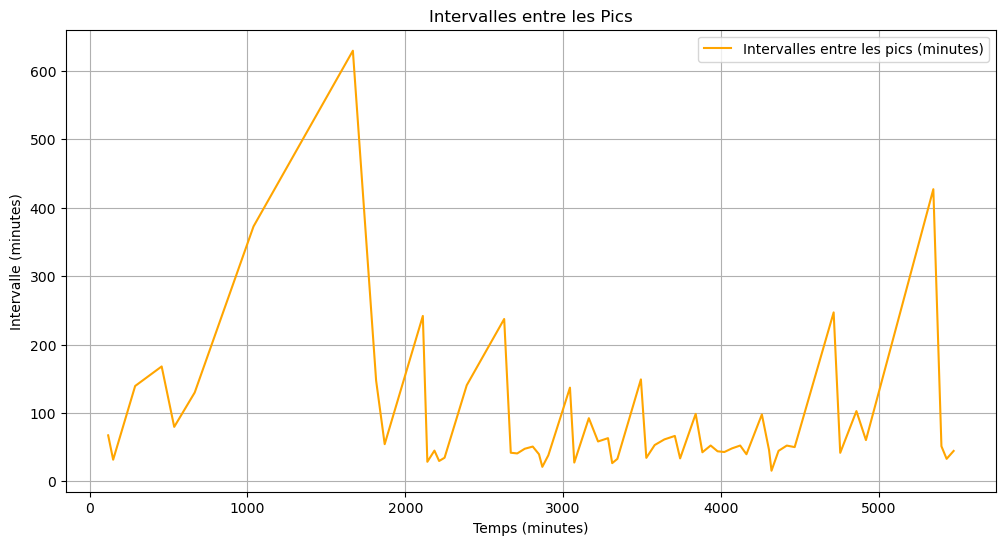

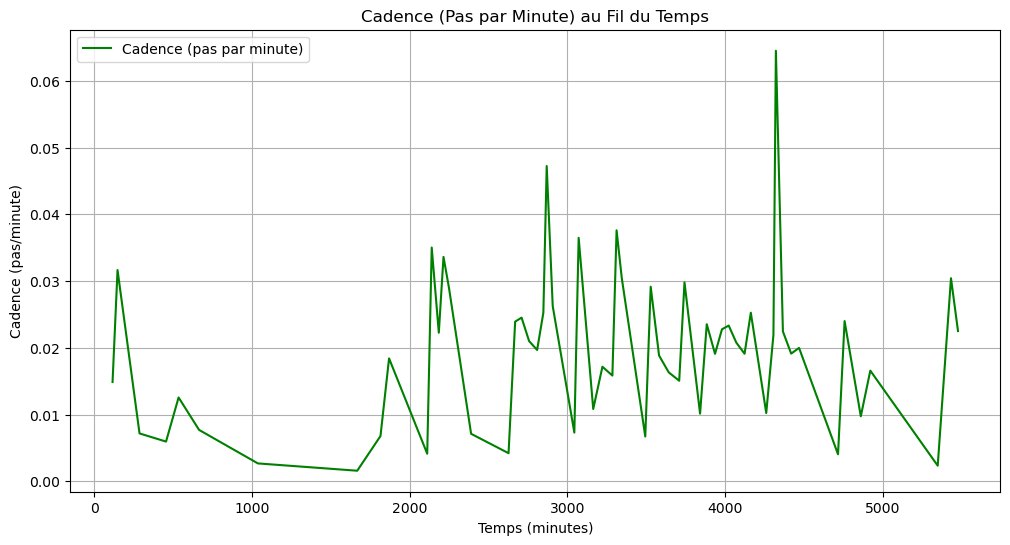

In [7]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Sélectionnez l'axe pertinent (par exemple, axe Z)
signal_column = signal_columns[2]  # Supposons que l'axe Z est la troisième colonne

# Détectez les pics dans le signal filtré
peaks, _ = find_peaks(data[signal_column], height=0)  # Ajustez 'height' si nécessaire

# Calculez les temps associés aux pics détectés
peak_times = data['relative_time_minutes'].iloc[peaks]

# Calculez les intervalles entre les pics (en minutes)
intervals = peak_times.diff().dropna()

# Convertissez les intervalles en cadence (pas par minute)
cadence = 1 / intervals  # En pas par minute

# Affichez les statistiques
print(f"Nombre total de pics détectés : {len(peaks)}")
print(f"Intervalle moyen entre les pics : {intervals.mean():.2f} minutes")
print(f"Cadence moyenne : {cadence.mean():.2f} pas par minute")

# Visualisez le signal et les pics détectés
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data[signal_column], label="Signal Z")
plt.plot(peak_times, data[signal_column].iloc[peaks], "x", label="Pics détectés", color='red')
plt.title("Détection des Pics et Analyse de la Cadence")
plt.xlabel("Temps (minutes)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez les intervalles entre les pics
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], intervals, label="Intervalles entre les pics (minutes)", color='orange')
plt.title("Intervalles entre les Pics")
plt.xlabel("Temps (minutes)")
plt.ylabel("Intervalle (minutes)")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez la cadence
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], cadence, label="Cadence (pas par minute)", color='green')
plt.title("Cadence (Pas par Minute) au Fil du Temps")
plt.xlabel("Temps (minutes)")
plt.ylabel("Cadence (pas/minute)")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
from skdh.preprocess import Calibrate, WearDetection
import pandas as pd

# Load your accelerometer data
file_path = "/Users/leasaab/Documents/Dev/AX3-Project/data/FemmeCardio.csv"
data = pd.read_csv(file_path)

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp_column'])

# Initialize calibrator and wear detection
calibrator = Calibrate()
wear_detector = WearDetection()

# Apply calibration (optional: depends on Axivity configuration)
data[['X', 'Y', 'Z']] = calibrator.fit_transform(data[['X', 'Y', 'Z']])

# Detect wear time to filter valid data
wear_time = wear_detector.fit_transform(data[['X', 'Y', 'Z']])
data['wear'] = wear_time
data = data[data['wear']]  # Keep only data where the device was worn

import lightgbm as lgb
print("LightGBM is working correctly!")

ModuleNotFoundError: No module named 'skdh.preprocess'